In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

MEMORY = 32*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

import pandas as pd
import seaborn as sns
from pde_solvers.cn import *
from local_utils import *
from turing.three_nodes_circuits import create_circuit_3954

1 Physical GPUs, 1 Logical GPUs


In [2]:
df = pd.read_csv("../with_diffusions_second_search/df_network_analysis_full_topology_with_estimates.csv")
df["adj_tup"] = df["adj_tup"].apply(lambda x: eval(f"tuple({x})"))
df["Adj"] = df["adj_tup"].apply(lambda x: np.array(x).reshape((3,3)))
adj=np.array([[1, 1, -1], [-1, 0, -1], [0, -1, 1]])
subnet_list = [g[1] for g in df.groupby("adj_tup") if g[0] == tuple(adj.flatten())]
if len(subnet_list) == 0:
    print("================================")
    print("There is no adjacancy matrix as: ", adj)
    print("================================")
else:
    subnet_df = subnet_list[0]

In [3]:
def load_dataset(path):
    with open(f"../{path}", "rb") as f:
        k_max, params, res = np.load(f, allow_pickle=True)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
           
    return (params, res, k_max)

In [92]:
n_max = 20
with open(f"./temp/temp_file.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)

In [15]:
@tf.function
def grads(pinn, H):
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    
    with tf.GradientTape(persistent=True) as tape:        
        H = flatten(H)
        tape.watch(H)
        
        outputs = pinn.net(H)
        Ag = tf.squeeze(outputs[:, 0])
        Bg = tf.squeeze(outputs[:, 1])
        Cg = tf.squeeze(outputs[:, 2])
        

        grad_A = tape.gradient(Ag, H)
        A_x = grad_A[:, 0]
        A_y = grad_A[:, 1]
        A_t = grad_A[:, 2]

        grad_B = tape.gradient(Bg, H)
        B_x = grad_B[:, 0]
        B_y = grad_B[:, 1]
        B_t = grad_B[:, 2]


        grad_A_x = tape.gradient(A_x, H)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, H)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, H)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, H)
        B_yy = grad_B_y[:, 1]
        
        
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            tf.squeeze(Cg)
           )                               


In [127]:
def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)

def rmse(arr1, arr2):
    return np.sqrt(np.mean((arr1-arr2)**2))

def get_pinn_outputs(index, pinn):
    slice_min = 45
    slice_max = 100
    
    print("="*40)
    path = subnet_df["path"].iloc[index]
    print(index, path)
    (params, res_1, k_max) = load_dataset(path)

    n_val = params["n"]
    mu_A_val, mu_B_val, mu_C_val = params["mu_A"], params["mu_B"], params["mu_C"]
    D_A = params["D_A"]
    D_B = params["D_B"]
    ##################################################
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))   
    ####################################################
    T=1    
    L=1
    data = reshape(res_1, T)
    nodes_n = data.shape[0]
    node_names = ["A", "B", "C"]
    x_size = data.shape[1]
    y_size = data.shape[2]
    ##########################################
    # Create a mesh that is the centers of the
    # original mesh
    x_size -= 1
    y_size -= 1
    dxdy = (10 - 10/127)**2/((x_size-1)*(y_size-1))
    ##########################
    N = x_size*y_size    
    t_star = np.arange(T, T+1)
    ##########################
    x_slice = slice(slice_min, slice_max, 1)
    y_slice = slice(slice_min, slice_max, 1)

    x_range = L * np.linspace(0, x_size, x_size+1)[x_slice]
    y_range = L * np.linspace(0, y_size, y_size+1)[y_slice]

    block_x = x_range.shape[0]
    block_y = y_range.shape[0]

    x = tf.constant(x_range, dtype=tf.float32)
    y = tf.constant(y_range, dtype=tf.float32)
    # The order of the Y and X must be reversed,
    # since the chnages the value finds the derivatives
    #Y, X = tf.meshgrid(x, y)

    X, Y = tf.meshgrid(x, y)
    ts = tf.constant(t_star, dtype=tf.float32)
    T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
    def H_cube(X, Y, T):
        return tf.concat(
                [
                    tf.concat(
                        [
                            X[tf.newaxis, :, :, tf.newaxis],
                            Y[tf.newaxis, :, :, tf.newaxis],
                            T[:, :, i : i + 1][tf.newaxis, :, :, :],
                        ],
                        axis=3,
                    )
                    for i in range(T.shape[-1])
                ],
                axis=0,
            )
    H = H_cube(X, Y, T) 
    #######################################
    c_xx_out =  np.array([[second_order_derivatives((128, 128), data[c, ..., t])[0]
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
    c_xx_out = np.einsum("ctij -> cijt", c_xx_out)
    c_yy_out = np.array([[second_order_derivatives((128, 128), data[c, ..., t])[1]
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
    c_yy_out = np.einsum("ctij -> cijt", c_yy_out)

    A_finit_diff_der = ( c_xx_out[0,:, :  , -1] + c_yy_out[0,:, :  , -1])[x_slice, y_slice]
    B_finit_diff_der = ( c_xx_out[1,:, :  , -1] + c_yy_out[1,:, :  , -1])[x_slice, y_slice]
    finit_diff = np.stack([A_finit_diff_der, B_finit_diff_der])[..., np.newaxis]
    finit_diff  = np.einsum( "cxyt -> txyc", finit_diff) 
    ##########################################
    def Create_f_A(A, B, C, n, mu_A, A_diffu=None):
        def act(x, km, n=4):
            return 1 / (1 + (km / (x + 1e-20)) ** (n))

        def inh(x, km, n=4):
            return 1 / (1 + (x / (km + 1e-20)) ** (n))
        A_flat = A#.flatten()[np.newaxis, :]
        B_flat = B#.flatten()[np.newaxis, :]           
        #A_diffu =  0.01* diffu_2D(A).flatten()[np.newaxis, :]
        if A_diffu is None:
            dxdy = (10*10)/((A.shape[0]-1)*(A.shape[1]-1))
            A_diffu = ((1.0/dxdy)*(diffusion((A.shape[0],A.shape[1]),A))).flatten()[np.newaxis, :]

        def L_2_f_a(args):
            (b_A, V_A,  K_AA, K_BA
            ) = (args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4])
            f1 = (b_A + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n) - mu_A*A_flat 
                  + D_A*A_diffu)
            f2 = (b_A/(D_A+1e-6) + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n)/(D_A+1e-6) 
                  - mu_A*A_flat/(D_A+1e-6) + A_diffu)

            return np.sum((f1**2 + f2**2 )/A_flat.size, axis=1)
        return L_2_f_a

    def Create_f_A_1_D(A, B, C, n, mu_A, A_diffu=None):
        def act(x, km, n=4):
            return 1 / (1 + (km / (x + 1e-20)) ** (n))

        def inh(x, km, n=4):
            return 1 / (1 + (x / (km + 1e-20)) ** (n))
        A_flat = A#.flatten()[np.newaxis, :]
        B_flat = B#.flatten()[np.newaxis, :] 
        #A_diffu =  0.01* diffu_2D(A).flatten()[np.newaxis, :]
        if A_diffu is None:
            dxdy = (10*10)/((A.shape[0]-1)*(A.shape[1]-1))
            A_diffu = ((1.0/dxdy)*(diffusion((A.shape[0],A.shape[1]),A))).flatten()[np.newaxis, :]
        def L_2_f_a(args):        
            (b_A,V_A, K_AA, K_BA
            ) = (args[0], args[1], args[2], args[3])
            f1 = (b_A + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n) - mu_A*A_flat 
                  + D_A*A_diffu)
            f2 = (b_A/(D_A+1e-6) + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n)/(D_A+1e-6) 
                  - mu_A*A_flat/(D_A+1e-6) + A_diffu)

            return np.sum((f1**2 + f2**2 )/A_flat.size, axis=1)
        return L_2_f_a

    def Create_f_B(A, B, C, n, mu_B, B_diffu=None):
        def act(x, km, n=4):
            return 1 / (1 + (km / (x + 1e-20)) ** (n))

        def inh(x, km, n=4):
            return 1 / (1 + (x / (km + 1e-20)) ** (n))
        A_flat = A#.flatten()[np.newaxis, :]
        B_flat = B#.flatten()[np.newaxis, :]   
        C_flat = C#.flatten()[np.newaxis, :]
        #B_diffu =  1.0* diffu_2D(B).flatten()[np.newaxis, :]
        if B_diffu is None:
            dxdy = (10*10)/((B.shape[0]-1)*(B.shape[1]-1))
            B_diffu = ((1.0/dxdy)*(diffusion((B.shape[0],B.shape[1]),B))).flatten()[np.newaxis, :]    
        def L_2_f_b(args):
            (b_B, V_B, K_AB, K_CB
            ) = (args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4])
            f1 = (b_B + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n) - mu_B*B_flat 
                 + D_B*B_diffu)
            f2 = (b_B/(D_B + 1e-6) + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n)/(D_B + 1e-6)
                  - mu_B*B_flat/(D_B + 1e-6)  + B_diffu)
            return np.sum((f1**2 + f2**2 )/B_flat.size, axis=1)
        return L_2_f_b

    def Create_f_B_1_D(A, B, C, n, mu_B, B_diffu=None):
        def act(x, km, n=4):
            return 1 / (1 + (km / (x + 1e-20)) ** (n))

        def inh(x, km, n=4):
            return 1 / (1 + (x / (km + 1e-20)) ** (n))
        A_flat = A#.flatten()[np.newaxis, :]
        B_flat = B#.flatten()[np.newaxis, :]   
        C_flat = C#.flatten()[np.newaxis, :]
        #B_diffu =  1.0* diffu_2D(B).flatten()[np.newaxis, :]
        if B_diffu is None:
            dxdy = (10*10)/((B.shape[0]-1)*(B.shape[1]-1))
            B_diffu = ((1.0/dxdy)*(diffusion((B.shape[0],B.shape[1]),B))).flatten()[np.newaxis, :]
        def L_2_f_b(args):        
            (b_B, V_B,K_AB, K_CB
            )  = (args[0], args[1], args[2], args[3])
            f1 = (b_B + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n) - mu_B*B_flat 
                 + D_B*B_diffu)
            f2 = (b_B/(D_B + 1e-6) + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n)/(D_B + 1e-6)
                  - mu_B*B_flat/(D_B + 1e-6)  + B_diffu)
            return np.sum((f1**2 + f2**2 )/B_flat.size, axis=1)
        return L_2_f_b

    def Create_f_C(A, B, C, n, mu_C):
        def act(x, km, n=4):
            return 1 / (1 + (km / (x + 1e-20)) ** (n))

        def inh(x, km, n=4):
            return 1 / (1 + (x / (km + 1e-20)) ** (n))
        A_flat = A#.flatten()[np.newaxis, :]
        B_flat = B#.flatten()[np.newaxis, :]   
        C_flat = C#.flatten()[np.newaxis, :]
        def L_2_f_c(args):
            b_C, V_C, K_AC, K_BC, K_CC = args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4], args[:, 4:5]
            #b_C, V_C, K_AC, K_BC, K_CC = args[0], args[1], args[2], args[3], args[4]
            f = b_C + V_C*inh(A_flat, K_AC, n)*inh(B_flat, K_BC, n)*act(C_flat, K_CC, n) - mu_C * C_flat
            return np.sum(f**2, axis=1)
        return L_2_f_c

    def Create_f_C_1_D(A, B, C, n, mu_C):
        def act(x, km, n=4):
            return 1 / (1 + (km / (x + 1e-20)) ** (n))

        def inh(x, km, n=4):
            return 1 / (1 + (x / (km + 1e-20)) ** (n))
        A_flat = A#.flatten()[np.newaxis, :]
        B_flat = B#.flatten()[np.newaxis, :]   
        C_flat = C#.flatten()[np.newaxis, :]
        def L_2_f_c(args):        
            b_C, V_C, K_AC, K_BC, K_CC = args[0], args[1], args[2], args[3], args[4]
            f = b_C + V_C*inh(A_flat, K_AC, n)*inh(B_flat, K_BC, n)*act(C_flat, K_CC, n) - mu_C * C_flat
            return np.sum(f**2)
        return L_2_f_c

    ##########################################
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)
    
    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     C, 
    ) = grads(pinn, H)
    # Rmeomve the boundary effects due to convolutions, etc.
    sub_slice = slice(2,-2,1)
    A = to(A).copy()[sub_slice, sub_slice]
    B = to(B).copy()[sub_slice, sub_slice]
    C = to(C).copy()[sub_slice, sub_slice]
    A_diff = to((A_xx + A_yy))[sub_slice, sub_slice]
    B_diff = to((B_xx + B_yy))[sub_slice, sub_slice]
    # Transform back to the original space
    A = (((A+1)*(A_max-A_min))/2) + A_min
    B = (((B+1)*(B_max-B_min))/2) + B_min
    C = (((C+1)*(C_max-C_min))/2) + C_min
    A_diff = A_diff*(A_max-A_min)/2
    B_diff = B_diff*(B_max-B_min)/2
    # Flatten the arrays
    A_flatten = A.flatten()[np.newaxis, :]
    B_flatten = B.flatten()[np.newaxis, :]
    C_flatten = C.flatten()[np.newaxis, :]
    A_diff_flatten = A_diff.flatten()[np.newaxis, :]/dxdy
    B_diff_flatten = B_diff.flatten()[np.newaxis, :]/dxdy
    #####################################################
    f_a_loss = Create_f_A(A_flatten, B_flatten, C_flatten, 4, params["mu_A"], A_diff_flatten)
    f_a_loss_1_D = Create_f_A_1_D(A_flatten, B_flatten, C_flatten, 4, params["mu_A"], A_diff_flatten)
    f_b_loss = Create_f_B(A_flatten, B_flatten, C_flatten, 4, params["mu_B"], B_diff_flatten)
    f_b_loss_1_D = Create_f_B_1_D(A_flatten, B_flatten, C_flatten, 4, params["mu_B"], B_diff_flatten)
    f_c_loss = Create_f_C(A_flatten, B_flatten, C_flatten, 4, params["mu_C"])
    f_c_loss_1_D = Create_f_C_1_D(A_flatten, B_flatten, C_flatten, 4, params["mu_C"])
    
    Ao = data[0, x_slice, y_slice, -1][sub_slice, sub_slice].flatten()[np.newaxis, :]
    Bo = data[1, x_slice, y_slice, -1][sub_slice, sub_slice].flatten()[np.newaxis, :]
    Co = data[2, x_slice, y_slice, -1][sub_slice, sub_slice].flatten()[np.newaxis, :]
    A_finit_diff_dero = A_finit_diff_der[sub_slice, sub_slice].flatten()[np.newaxis, :]/dxdy
    B_finit_diff_dero = B_finit_diff_der[sub_slice, sub_slice].flatten()[np.newaxis, :]/dxdy
    
    f_a_loss_1_Do = Create_f_A_1_D(Ao, Bo, Co, 4, params["mu_A"], A_finit_diff_dero)
    f_b_loss_1_Do = Create_f_B_1_D(Ao, Bo, Co, 4, params["mu_B"], B_finit_diff_dero)
    f_c_loss_1_Do = Create_f_C_1_D(Ao, Bo, Co, 4, params["mu_C"])
    #######################################################    
    
    return (path, A, B, C, A_diff, B_diff,
            A_flatten, B_flatten, C_flatten, A_diff_flatten, B_diff_flatten,
            params, data, A_finit_diff_der, B_finit_diff_der,
            x_slice, y_slice, sub_slice,
            f_a_loss, f_a_loss_1_D, f_b_loss, f_b_loss_1_D, f_c_loss, f_c_loss_1_D,
            f_a_loss_1_Do, f_b_loss_1_Do, f_c_loss_1_Do)

In [149]:
index = 38
run = "no_noise"
pinn = tu.NN.restore(".", f"pinn_final_last_epoch_{index}_{run}")
with open(f"./temp/res_{index}_{run}.npy", "rb") as f:
    (A_max, A_min, 
     B_max, B_min, 
     C_max, C_min, 
     min_validation)= np.load(f, allow_pickle=True)
    print(f"A_min={A_min:.10f}, A_max={A_max:.10f}")
    print(f"B_min={B_min:.10f}, B_max={B_max:.10f}")
    print(f"C_min={C_min:.10f}, C_max={C_max:.10f}")
    print(f"min_validation={min_validation:.10f}")

A_min=0.0831491517, A_max=1.3895065937
B_min=7.9480421721, B_max=13.1907743490
C_min=2.8647744651, C_max=36.1776535723
min_validation=0.0000459278


In [150]:
(path, A, B, C, A_diff, B_diff,
 A_flatten, B_flatten, C_flatten, A_diff_flatten, B_diff_flatten,
params, data, A_finit_diff_der, B_finit_diff_der,
x_slice, y_slice, sub_slice,
f_a_loss, f_a_loss_1_D, f_b_loss, f_b_loss_1_D, f_c_loss, f_c_loss_1_D,
f_a_loss_1_Do, f_b_loss_1_Do, f_c_loss_1_Do) = get_pinn_outputs(index, pinn)

38 outputs_second_search/solution_10_3_77.npy


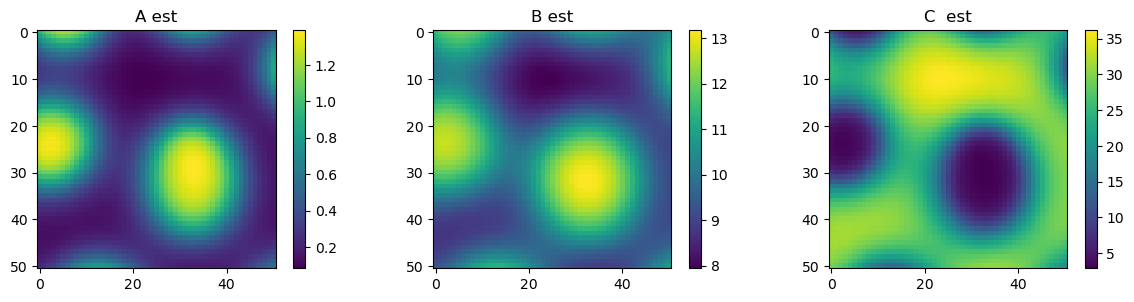

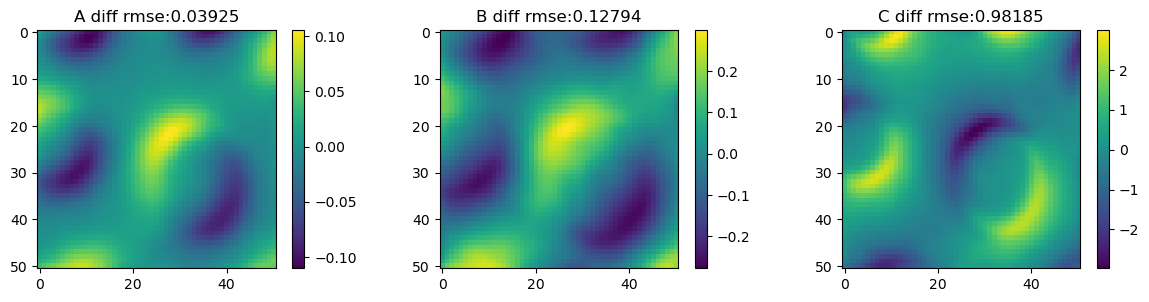

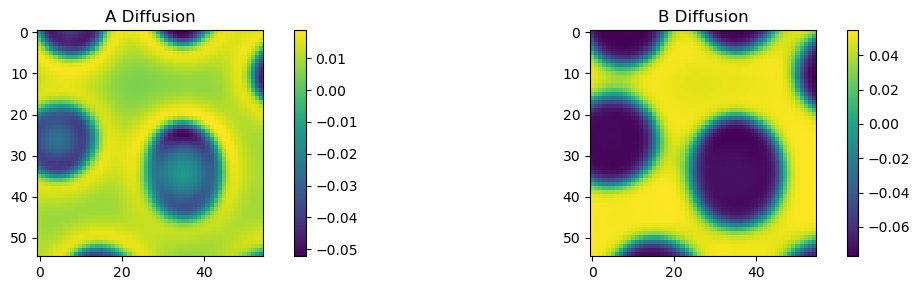

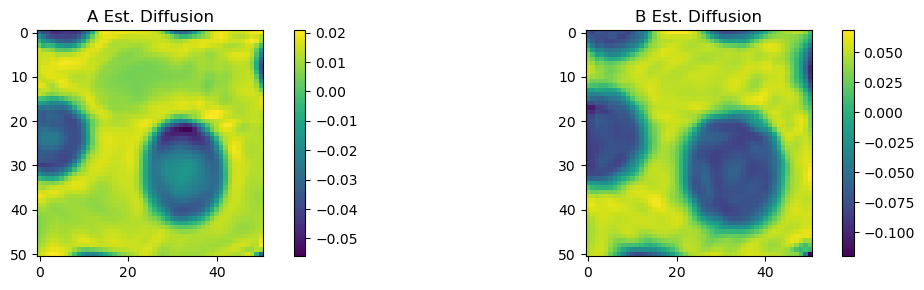

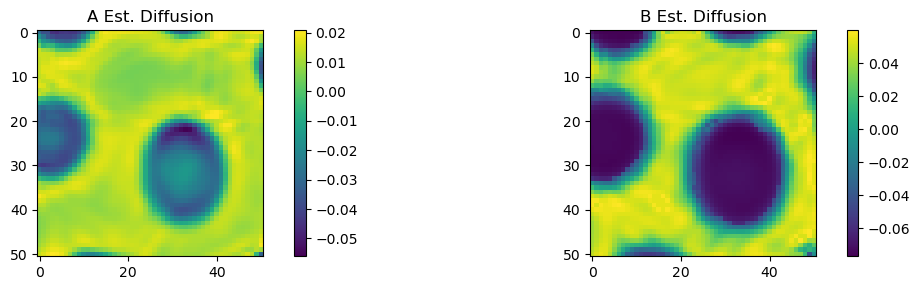

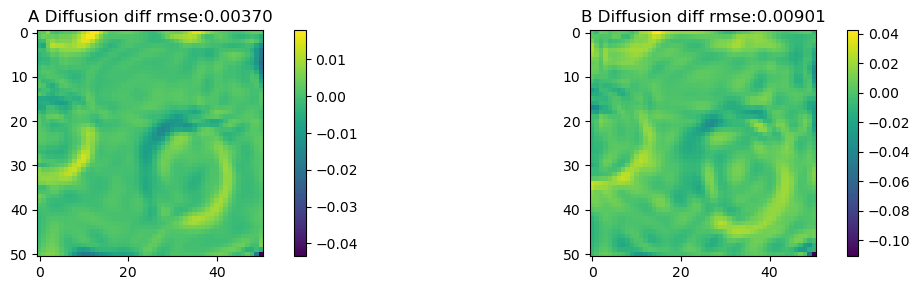

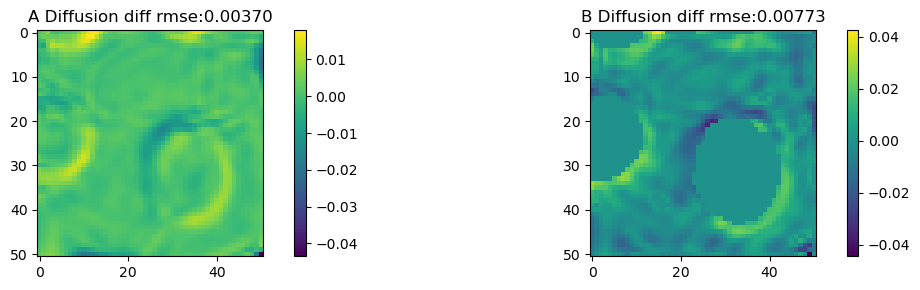

In [151]:
plot_n_im([A, B, C], 
  ["A est", "B est", "C  est"],          
  figsize=(12, 3)); plt.tight_layout();plt.show()

rmse1=rmse(A,data[0, x_slice, y_slice, -1][sub_slice, sub_slice])
rmse2=rmse(B,data[1, x_slice, y_slice, -1][sub_slice, sub_slice])
rmse3=rmse(C,data[2, x_slice, y_slice, -1][sub_slice, sub_slice])
plot_n_im([A-data[0, x_slice, y_slice, -1][sub_slice, sub_slice], 
           B-data[1, x_slice, y_slice, -1][sub_slice, sub_slice],
           C-data[2, x_slice, y_slice, -1][sub_slice, sub_slice]], 
      [f"A diff rmse:{rmse1:.5f}", 
       f"B diff rmse:{rmse2:.5f}", 
       f"C diff rmse:{rmse3:.5f}"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([A_finit_diff_der, B_finit_diff_der], 
      ["A Diffusion", "B Diffusion"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([A_diff, B_diff], 
      ["A Est. Diffusion", "B Est. Diffusion"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

A_diff_copy = A_diff.copy()
A_diff_copy[ A_diff_copy > 1.] = A_finit_diff_der[sub_slice, sub_slice][A_diff_copy > 1.]
A_diff_copy[ A_diff_copy < -0.6] = A_finit_diff_der[sub_slice, sub_slice][A_diff_copy < -0.6]
B_diff_copy = B_diff.copy()
B_diff_copy[ B_diff_copy > 0.06] = B_finit_diff_der[sub_slice, sub_slice][B_diff_copy > 0.06]
B_diff_copy[ B_diff_copy < -0.05] = B_finit_diff_der[sub_slice, sub_slice][B_diff_copy < -0.05]
plot_n_im([A_diff_copy, B_diff_copy], 
      ["A Est. Diffusion", "B Est. Diffusion"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

rmse1=rmse(A_diff,A_finit_diff_der[sub_slice, sub_slice])
rmse2=rmse(B_diff,B_finit_diff_der[sub_slice, sub_slice])
plot_n_im([A_diff-A_finit_diff_der[sub_slice, sub_slice], 
           B_diff-B_finit_diff_der[sub_slice, sub_slice]], 
      [f"A Diffusion diff rmse:{rmse1:.5f}", 
       f"B Diffusion diff rmse:{rmse2:.5f}"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

rmse1=rmse(A_diff_copy,A_finit_diff_der[sub_slice, sub_slice])
rmse2=rmse(B_diff_copy,B_finit_diff_der[sub_slice, sub_slice])
plot_n_im([A_diff_copy-A_finit_diff_der[sub_slice, sub_slice], 
           B_diff_copy-B_finit_diff_der[sub_slice, sub_slice]], 
      [f"A Diffusion diff rmse:{rmse1:.5f}", 
       f"B Diffusion diff rmse:{rmse2:.5f}"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

In [152]:
(f_a_loss_1_Do((params["b_A"], params["V_A"], params["K_AA"], params["K_BA"])), 
 f_b_loss_1_Do((params["b_B"], params["V_B"], params["K_AB"], params["K_CB"])),
 f_c_loss_1_Do((params["b_C"], params["V_C"], params["K_AC"], params["K_BC"], params["K_CC"])))

(array([0.08248228]), array([0.00090803]), 42.09556600870707)

In [153]:
(f_a_loss_1_D((params["b_A"], params["V_A"], params["K_AA"], params["K_BA"])),
 f_b_loss_1_D((params["b_B"], params["V_B"], params["K_AB"], params["K_CB"])),
 f_c_loss_1_D((params["b_C"], params["V_C"], params["K_AC"], params["K_BC"], params["K_CC"])))

(array([0.15956146], dtype=float32),
 array([1.9799144], dtype=float32),
 45.71398)

In [107]:
results[32].keys()

dict_keys(['index', 'run', 'path', 'A_max', 'A_min', 'B_max', 'B_min', 'C_max', 'C_min', 'final_loss_A', 'final_params_A', 'init_loss_A', 'init_params_A', 'final_loss_B', 'final_params_B', 'init_loss_B', 'init_params_B', 'final_loss_C', 'final_params_C', 'init_loss_C', 'init_params_C'])

In [155]:
from scipy.optimize import minimize

def cos_dist(arr1, arr2):
    arr1_L = np.sqrt(np.dot(arr1, arr1))
    arr2_L = np.sqrt(np.dot(arr2, arr2))
    return np.dot(arr1, arr2)/(arr1_L*arr2_L)

def alienor_components2(epsilon, l1, bounds):
    """
    
    Args:
          epsilon (float): The accuracy of the estimates.
          l1 (float): Lipschitz constant
          bounds (list of tuples):
          bounds like [a_i, b_i], for each variables separatly.
          
          
    """
    n = len(bounds) 
    assert n >= 2, "The method expects two or more vairbales."
    assert np.all([len(item) == 2 
                   for item in bounds]), "bounds must be tuple of (a_i,b_i)"
    
    alpha = epsilon/(2*l1*np.sqrt(n-1))
    alphas = np.ones(n)
    
    def get_h_i(a,b,alpha):
        def h_i(t):
            return (a-b)*np.cos(alpha*t)/2 + (a+b)/2
        return h_i
    a,b = bounds[0]
    h_i = get_h_i(a,b,1)
    h_list = [h_i]
    for i in range(1, n):
        # [a_i, b_i]
        a,b = bounds[i]
        # alphas[i-1] (alpha/pi) / (|b_i| + |a_i|)
        alphas[i] = alpha*alphas[i-1]/(np.pi*(np.abs(b)+np.abs(a)))
        # h_i = (a_i - b_i)cos(alpha_i theta)/2 +  (a_i + b_i)/2         
        h_i = h_i = get_h_i(a,b,alphas[i])#
        h_list.append(h_i)        
        
        
    # l2 or Lipschitz constant of the aliemor h functions
    l2 = np.linalg.norm([(np.abs(d[1])+np.abs(d[0]))**2 * a**2 for d,a in zip(bounds,alphas) ])/2
    #
    theta_max = np.pi/alphas[-1]    
    return alpha, alphas, l2, h_list, theta_max

def minim_2(epsilon, l1, bounds, func, maxiter=10000):
    alpha, alphas, l2, h_list, theta_max = alienor_components2(epsilon, l1, bounds)
    k = 1
    L = l1 * l2
    theta = epsilon / L    
    theta_epsilon = theta
    
    f = lambda t: func(*[ h(t) for h in h_list])
    f_epsilon = f_theta = f(theta_epsilon)
    
    while k < maxiter:
        if theta > np.pi/alphas[-1]:            
            return k, theta,theta_epsilon, f_epsilon, ""
        
        theta = theta + (epsilon + f_theta - f_epsilon)/ L        
        f_theta  =  f(theta)
        if f_theta < f_epsilon:
            f_epsilon = f_theta
            theta_epsilon = theta
        k += 1    
    return k, theta,theta_epsilon, f_epsilon, f"max iteration '{maxiter}' is reached"

In [191]:
bounds_A = [(0,30), (0,200), (0,30), (0,30)]
bounds_B = [(0,30), (0,200), (0,30), (0,30)]
bounds_C = [(0,30), (0,200), (0,30), (0,30), (0,30)]
epsilon = 1e-4
l1 = 1

alpha_A, alphas_A, l2_A, h_list2_A, theta_max2_A = alienor_components2(epsilon, l1, bounds_A)
alpha_B, alphas_B, l2_B, h_list2_B, theta_max2_B = alienor_components2(epsilon, l1, bounds_B)
alpha_C, alphas_C, l2_C, h_list2_C, theta_max2_C = alienor_components2(epsilon, l1, bounds_C)
L_A = l1*l2_A
L_B = l1*l2_B
L_C = l1*l2_C
print("delta theta A:", epsilon/L_A)
print("delta theta A:", L_A/epsilon)
print()
print("delta theta B:", epsilon/L_B)
print("delta theta B:", L_B/epsilon)
print()
print("delta theta C:", epsilon/L_C)
print("delta theta C:", L_C/epsilon)

batch_size = 10000
print("A epochs:", L_A/epsilon/batch_size)
print("B epochs:", L_B/epsilon/batch_size)
print("C epochs:", L_C/epsilon/batch_size)

thetas_A = np.linspace(0, theta_max2_A,  int(L_A/epsilon))
thetas_B = np.linspace(0, theta_max2_B,  int(L_B/epsilon))
thetas_C = np.linspace(0, theta_max2_C,  int(L_C/epsilon))

params_by_theta_A = np.stack([h_list2_A[0](thetas_A), h_list2_A[1](thetas_A),
                              h_list2_A[2](thetas_A), h_list2_A[3](thetas_A)]).T

params_by_theta_B = np.stack([h_list2_B[0](thetas_B), h_list2_B[1](thetas_B),
                              h_list2_B[2](thetas_B), h_list2_B[3](thetas_B)]).T

params_by_theta_C = np.stack([h_list2_C[0](thetas_C), h_list2_C[1](thetas_C),
                              h_list2_C[2](thetas_C), h_list2_C[3](thetas_C),
                              h_list2_C[4](thetas_C)]).T

theta_A_n = params_by_theta_A.shape[0]
theta_A_m = params_by_theta_A.shape[1]
theta_B_n = params_by_theta_B.shape[0]
theta_B_m = params_by_theta_B.shape[1]
theta_C_n = params_by_theta_C.shape[0]
theta_C_m = params_by_theta_C.shape[1]

delta theta A: 2.2222222222222224e-07
delta theta A: 4500000.0

delta theta B: 2.2222222222222224e-07
delta theta B: 4500000.0

delta theta C: 2.2222222222222224e-07
delta theta C: 4500000.0
A epochs: 450.0
B epochs: 450.0
C epochs: 450.0


In [192]:
from multiprocessing import Pool, shared_memory
def singA(args):
    batch_id,theta_n,theta_m= args 
    params_shm = shared_memory.SharedMemory(name="params_by_theta4")
    output_shm = shared_memory.SharedMemory(name="outputs4")
    thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
    f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
    f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_a_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
    return batch_id

def singB(args):
    batch_id,theta_n,theta_m= args 
    params_shm = shared_memory.SharedMemory(name="params_by_theta4")
    output_shm = shared_memory.SharedMemory(name="outputs4")
    thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
    f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
    f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_b_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
    return batch_id

def singC(args):
    batch_id,theta_n,theta_m= args 
    params_shm = shared_memory.SharedMemory(name="params_by_theta4")
    output_shm = shared_memory.SharedMemory(name="outputs4")
    thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
    f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
    f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_c_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
    return batch_id

#_LocalFunctions.add_functions(singA, singB, singC)

def run(theta_n,theta_m,params_by_theta, sing, L, epsilon, batch_size):
    shm = shared_memory.SharedMemory(name="params_by_theta4",
                                     create=True, 
                                     size=params_by_theta.nbytes)
    shared_thetas = np.ndarray((theta_n,theta_m), dtype=np.float64,
                                buffer=shm.buf)

    shared_thetas[:,:] = params_by_theta[:,:]


    f_thetas = np.zeros(theta_n)
    shm_out = shared_memory.SharedMemory(name="outputs4",create=True, size=f_thetas.nbytes)
    shared_outputs = np.ndarray((theta_n), dtype=np.float64,
                                 buffer=shm_out.buf)


    args =[ (batch_id, theta_n,theta_m) for batch_id in range(int(L/epsilon/batch_size) + 1)]

    with Pool(55) as pool:
        res = pool.map(sing, args)

    f_thetas[:] = shared_outputs[:]
    shm.close()
    shm.unlink()

    shm_out.close()
    shm_out.unlink()

    return f_thetas

f_thetas_A = run(theta_A_n,theta_A_m,params_by_theta_A, singA, L_A, epsilon, batch_size)
f_thetas_B = run(theta_B_n,theta_B_m,params_by_theta_B, singB, L_B, epsilon, batch_size)
f_thetas_C = run(theta_C_n,theta_C_m,params_by_theta_C, singC, L_C, epsilon, batch_size)


In [178]:
f_thetas_A

array([5.69390308e+01, 8.97260633e+06, 5.57765857e+01, ...,
       8.41337355e+02, 1.04666427e+06, 7.99923896e+06])

In [179]:
def minimise_top_n(n, h_list, bounds, loss_1_D, f_thetas, thetas):
    shift = 0
    init_params = np.zeros((n, len(h_list)))
    final_params = np.zeros((n, len(h_list)))
    init_loss = np.zeros(n)
    final_loss = np.zeros(n)

    top_n = np.argpartition(-f_thetas, -n)[-n:]
    top_n = top_n[np.argsort(f_thetas[top_n])]

    for shift in range(n):

        theta_star = thetas[top_n][0 + shift]
        init_par = tuple([h(theta_star) for h in h_list])
        init_params[shift, :] = init_par
        init_loss[shift] = f_thetas[top_n][0 + shift]
        #bounds = ((0, 200), (0, 200), (0, 200), (0, 200), (0, 200))
        res3= minimize(loss_1_D, x0=init_par, method='L-BFGS-B', bounds=bounds)#, options={'ftol':1e-10})
        final_params[shift, :] = res3['x']
        final_loss[shift] = res3['fun']

    sorted_loss_ind = np.argsort(final_loss)
    init_params = init_params[sorted_loss_ind.tolist()]
    init_loss = init_loss[sorted_loss_ind.tolist()]
    final_params = final_params[sorted_loss_ind.tolist()]
    final_loss = final_loss[sorted_loss_ind.tolist()]

    return (final_loss, final_params, init_loss, init_params )

(final_loss_A, final_params_A, 
 init_loss_A, init_params_A) = minimise_top_n(n_max, h_list2_A, 
                                              ((0, 500), (0, 500), (0, 500), (0, 500)), 
                                              f_a_loss_1_D, f_thetas_A, thetas_A)

(final_loss_B, final_params_B, 
 init_loss_B, init_params_B) = minimise_top_n(n_max, h_list2_B, 
                                              ((0, 500), (0, 500), (0, 500), (0, 500)), 
                                              f_b_loss_1_D, f_thetas_B, thetas_B)

(final_loss_C, final_params_C, 
 init_loss_C, init_params_C) = minimise_top_n(n_max, h_list2_C, 
                                              ((0, 500), (0, 500), (0, 500), (0, 500), (0, 500)), 
                                              f_c_loss_1_D, f_thetas_C, thetas_C)


In [180]:
final_loss_A, final_loss_B, final_loss_C

(array([0.23304945, 0.23333079, 0.338413  , 0.35000437, 0.38721421,
        0.40145439, 0.44458282, 0.53078622, 0.97739166, 1.03710604,
        1.18936336, 1.426301  , 1.48846984, 1.58754563, 1.71785474,
        1.74632621, 1.88568425, 2.00948191, 2.21545887, 2.51033163]),
 array([2.12102938, 2.5090251 , 2.63222265, 2.68481302, 2.74622488,
        2.87412763, 2.91381836, 2.9290967 , 3.08107519, 3.08195639,
        3.45645285, 3.48770905, 3.49502063, 3.94160223, 4.00959969,
        4.0590744 , 4.13298416, 4.39583778, 4.39712906, 4.40673065]),
 array([237.20993042, 309.32156372, 415.31884766, 424.9574585 ,
        483.17523193, 497.51028442, 511.76940918, 519.44207764,
        586.98327637, 612.38104248, 668.8961792 , 713.33563232,
        763.26898193, 776.6161499 , 837.48571777, 864.46936035,
        880.09448242, 884.21240234, 899.5135498 , 922.40795898]))

In [126]:
import copy

D_A_val, D_B_val = 0.01, 1.0
N=5000
T=100
delta_t = T/N
model_128_10 = RD_2D_1st_Order(Ds=[D_A_val, D_B_val, 0], 
                               delta_t=delta_t, Lx=10, Ly=10, 
                               Ix=128, Jy=128,
                               boundary_condition=Neumann_Boundary_2D)



In [161]:
print(path)
(params, res_1, _) = load_dataset(path)    


outputs_second_search/solution_10_3_77.npy


In [188]:
A_init = res_1[0, 0, :]
B_init = res_1[0, 1, :]
C_init = res_1[0, 2, :]
n_val = params["n"]
mu_A_val = params["mu_A"]
mu_B_val = params["mu_B"]
mu_C_val = params["mu_C"]
b_A_val, V_A_val, K_AA_val, K_BA_val = final_params_A[2]#results[slice_d][i]['final_params_A'][k]
b_B_val, V_B_val, K_AB_val, K_CB_val = final_params_B[2]#results[slice_d][i]['final_params_B'][k]
b_C_val, V_C_val, K_AC_val, K_BC_val, K_CC_val = final_params_C[2]#results[slice_d][i]['final_params_C'][k]
kinetics = create_circuit_3954(n_val, 
                               b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                               b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                               b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)  

res_2 = model_128_10.integrate([A_init,B_init,C_init], kinetics, 5000-1, 500)


In [166]:
params

{'D_A': 0.01,
 'D_B': 1.0,
 'n': 4.0,
 'b_A': 0.001,
 'mu_A': 0.1,
 'V_A': 10.0,
 'K_AA': 1.0,
 'K_AB': 0.5,
 'K_AC': 1.0,
 'b_B': 0.1,
 'mu_B': 1.0,
 'V_B': 25.0,
 'K_BA': 5.0,
 'K_BC': 10.0,
 'b_C': 0.1,
 'mu_C': 0.5,
 'V_C': 25.0,
 'K_CB': 50.0,
 'K_CC': 0.5}

In [182]:
print(f"b_A:{b_A_val:.4f}, mu_A:{mu_A_val:.4f}, V_A:{V_A_val:.4f}, "
          f"K_AA:{K_AA_val:.4f}, K_AB:{K_AB_val:.4f}, K_AC:{K_AC_val:.4f}, "
          f"b_B:{b_B_val:.4f}, mu_B:{mu_B_val:.4f}, V_B:{V_B_val:.4f}, "
          f"K_BA:{K_BA_val:.4f}, K_BC:{K_BC_val:.4f}, "
          f"b_C:{b_C_val:.4f}, mu_C:{mu_C_val:.4f}, V_C:{V_C_val:.4f}, "
          f"K_CB:{K_CB_val:.4f}, K_CC:{K_CC_val:.4f}")  

b_A:0.0031, mu_A:0.1000, V_A:13.6496, K_AA:1.0301, K_AB:0.4440, K_AC:16.8808, b_B:0.2762, mu_B:1.0000, V_B:24.5409, K_BA:4.6186, K_BC:9.4902, b_C:2.2934, mu_C:0.5000, V_C:24.2502, K_CB:27.8189, K_CC:12.5584


In [189]:
print(f"b_A:{b_A_val:.4f}, mu_A:{mu_A_val:.4f}, V_A:{V_A_val:.4f}, "
          f"K_AA:{K_AA_val:.4f}, K_AB:{K_AB_val:.4f}, K_AC:{K_AC_val:.4f}, "
          f"b_B:{b_B_val:.4f}, mu_B:{mu_B_val:.4f}, V_B:{V_B_val:.4f}, "
          f"K_BA:{K_BA_val:.4f}, K_BC:{K_BC_val:.4f}, "
          f"b_C:{b_C_val:.4f}, mu_C:{mu_C_val:.4f}, V_C:{V_C_val:.4f}, "
          f"K_CB:{K_CB_val:.4f}, K_CC:{K_CC_val:.4f}") 

b_A:0.0000, mu_A:0.1000, V_A:0.2243, K_AA:0.7729, K_AB:0.3558, K_AC:27.8058, b_B:0.1431, mu_B:1.0000, V_B:24.6739, K_BA:19.9809, K_BC:10.2036, b_C:2.9840, mu_C:0.5000, V_C:20.8341, K_CB:22.9749, K_CC:15.1541


In [ ]:
'b_A': 0.001, 'mu_A': 0.1, 'V_A': 10.0, 'K_AA': 1.0, 'K_AB': 0.5, 'K_AC': 1.0, 'b_B': 0.1, 'mu_B': 1.0,
'V_B': 25.0, 'K_BA': 5.0, 'K_BC': 10.0, 'b_C': 0.1, 'mu_C': 0.5, 'V_C': 25.0, 'K_CB': 50.0, 'K_CC': 0.5

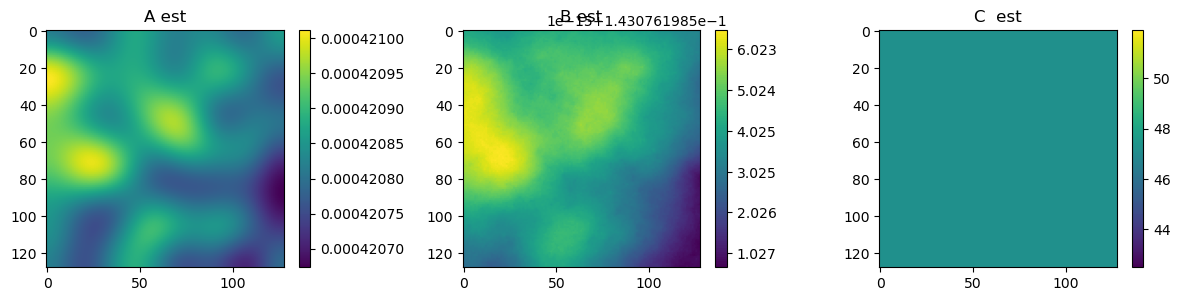

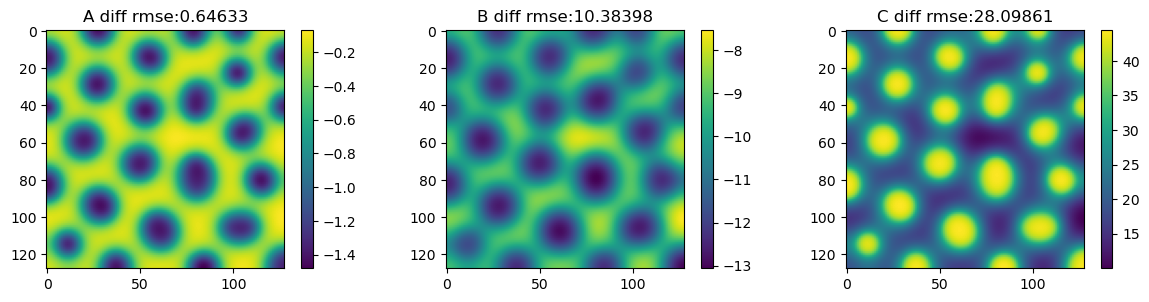

In [190]:
A = to(res_2[-1, 0, :])
B = to(res_2[-1, 1, :])
C = to(res_2[-1, 2, :])
plot_n_im([A, B, C], 
  ["A est", "B est", "C  est"],          
  figsize=(12, 3)); plt.tight_layout();plt.show()

rmse1=rmse(A,data[0, ..., -1])
rmse2=rmse(B,data[1, ..., -1])
rmse3=rmse(C,data[2, ..., -1])
plot_n_im([A-data[0, ..., -1], 
           B-data[1, ..., -1],
           C-data[2, ..., -1]], 
      [f"A diff rmse:{rmse1:.5f}", 
       f"B diff rmse:{rmse2:.5f}", 
       f"C diff rmse:{rmse3:.5f}"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

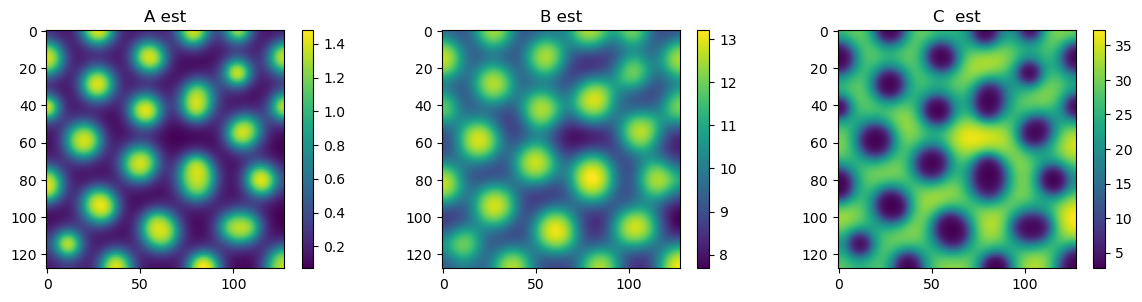

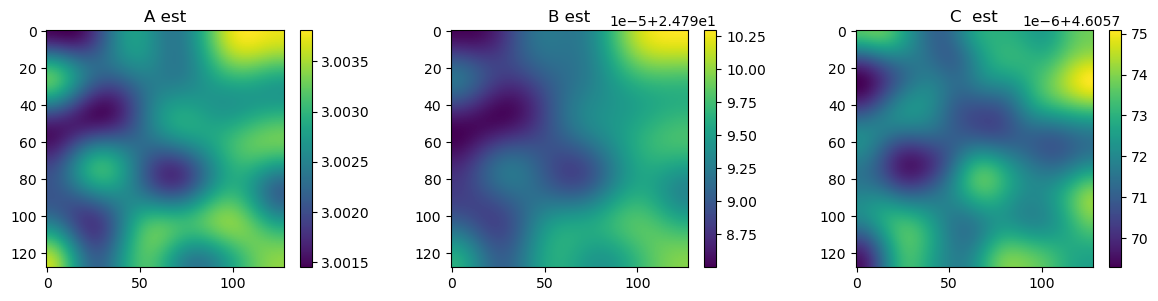

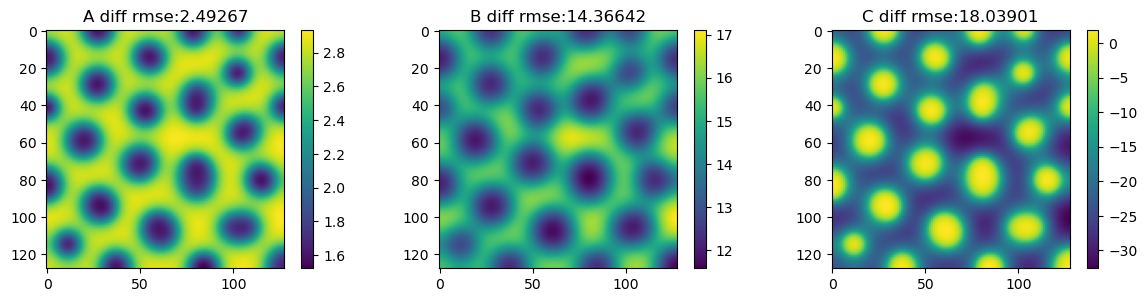

In [184]:
A = to(res_2[-1, 0, :])
B = to(res_2[-1, 1, :])
C = to(res_2[-1, 2, :])
plot_n_im([data[0, ..., -1], data[1, ..., -1], data[2, ..., -1]], 
  ["A est", "B est", "C  est"],          
  figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([A, B, C], 
  ["A est", "B est", "C  est"],          
  figsize=(12, 3)); plt.tight_layout();plt.show()

rmse1=rmse(A,data[0, ..., -1])
rmse2=rmse(B,data[1, ..., -1])
rmse3=rmse(C,data[2, ..., -1])
plot_n_im([A-data[0, ..., -1], 
           B-data[1, ..., -1],
           C-data[2, ..., -1]], 
      [f"A diff rmse:{rmse1:.5f}", 
       f"B diff rmse:{rmse2:.5f}", 
       f"C diff rmse:{rmse3:.5f}"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

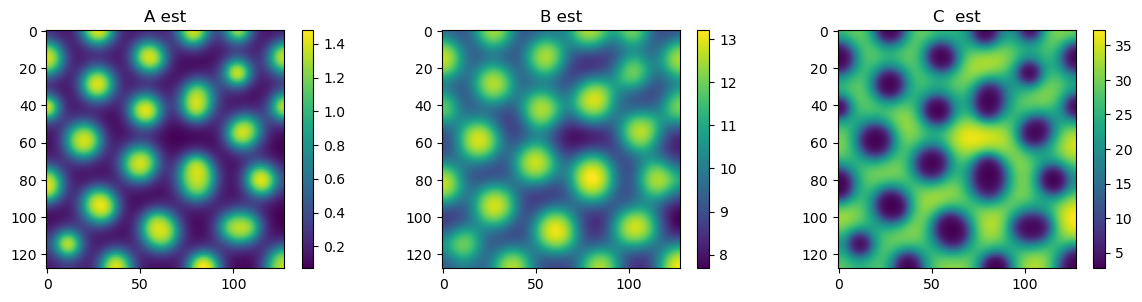

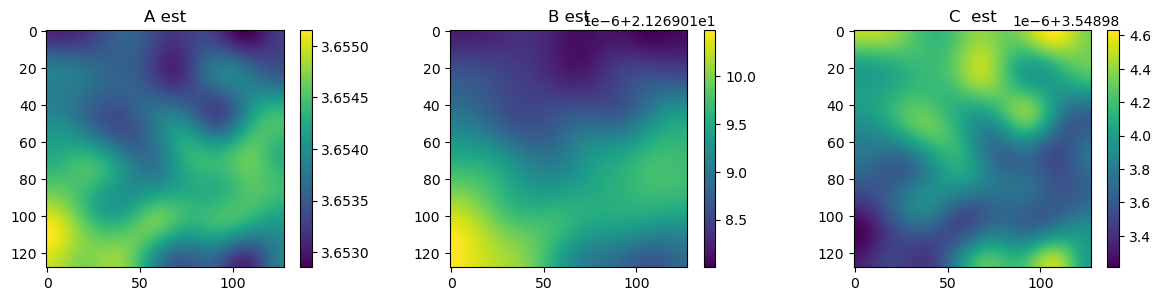

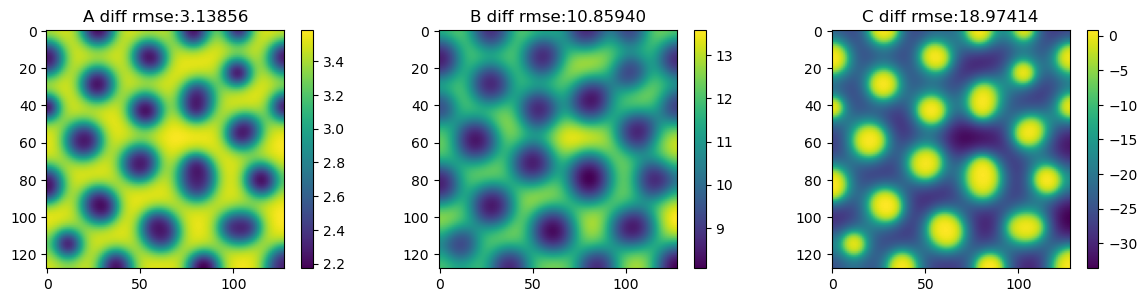

In [170]:
A = to(res_2[-1, 0, :])
B = to(res_2[-1, 1, :])
C = to(res_2[-1, 2, :])
plot_n_im([data[0, ..., -1], data[1, ..., -1], data[2, ..., -1]], 
  ["A est", "B est", "C  est"],          
  figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([A, B, C], 
  ["A est", "B est", "C  est"],          
  figsize=(12, 3)); plt.tight_layout();plt.show()

rmse1=rmse(A,data[0, ..., -1])
rmse2=rmse(B,data[1, ..., -1])
rmse3=rmse(C,data[2, ..., -1])
plot_n_im([A-data[0, ..., -1], 
           B-data[1, ..., -1],
           C-data[2, ..., -1]], 
      [f"A diff rmse:{rmse1:.5f}", 
       f"B diff rmse:{rmse2:.5f}", 
       f"C diff rmse:{rmse3:.5f}"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()